<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/weight_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [39]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # numpy array

# extract labels and drop labels from data:
labels = data[:,0] # extract
data   = data[:,1:] # drop

# always normalize both train & test data to [0 1]:
dataNorm = data / np.max(data)

In [40]:
# Step 1: convert to PyTorch tensors
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data (still tensors):
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape,test_data.shape, train_labels.shape,test_labels.shape)

# Step 3: PyTorch tensors -> PyTorch TensorDataset objects:
# combine data and label tensors into a single dataset object
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: PyTorch TensorDataset objects -> PyTorch dataloader objects
# shuffle the data to help model generalize better
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([2000, 784]) torch.Size([18000]) torch.Size([2000])


784 = 28^2

In [41]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64) # 784 input

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x) # NOTE: no softmax is needed with CEL

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss() # CEL internally computes log-softmax

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [42]:
### exploring the "innards" of the model

# create a temp model to explore
net = createTheMNISTNet()[0]

# summary of the entire model
print('Summary of model:')
print(net, "\n")

# explore one of the layers
print('Summary of input layer:')
print( vars(net.input), "\n" )

# check out the matrix of weights
print('Input layer weights:')
print( net.input.weight.shape )
print( net.input.weight, "\n" )

Summary of model:
mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
) 

Summary of input layer:
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0088, -0.0200,  0.0142,  ..., -0.0267,  0.0170, -0.0321],
        [-0.0114,  0.0266,  0.0292,  ..., -0.0062, -0.0310,  0.0199],
        [-0.0046, -0.0074, -0.0048,  ...,  0.0293, -0.0005, -0.0124],
        ...,
        [-0.0141, -0.0329,  0.0039,  ..., -0.0245, -0.0260,  0.0165],
        [ 0.0049,  0.0324, -0.0181,  ..., -0.0284, -0.0213,  0.0034],
        [ 0.0318,  0.0243, -0.0233,  ..., -0.0250,  0.0032,  0.0268]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([-0.0305,  0.0190, -0.0184, -0.0008, -0.0118, -0.0149,  0.0026,  0.0230,
         0.0166,  0.0329, -0.0112, -0.0136, 

👆The "bias" terms allow the network to introduce an offset or shift in the output.

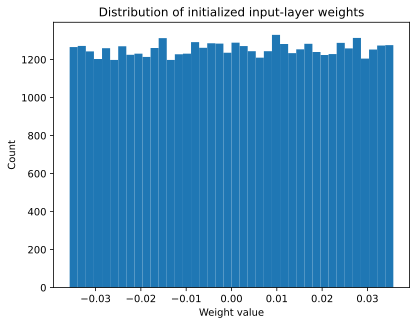

In [43]:
# finally, extract the weights and make a histogram
w = net.input.weight.detach().flatten() # .flatten(): matrix -> vector
# w = net.fc1.weight.detach().flatten()
# print(w.type) # Tensor object
plt.hist(w,40) # histogram be divided into 40 equal-width bins or columns.
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized input-layer weights')
plt.show()

👆What does does the `.detach()` do?
A new Tensor `w` is created that retains the values of `net.input.weight` at that particular point in time, but it is no longer associated with the computation graph that produced it.

Obeservations:

---

1.   symmetric around 0
2.   uniform distribution



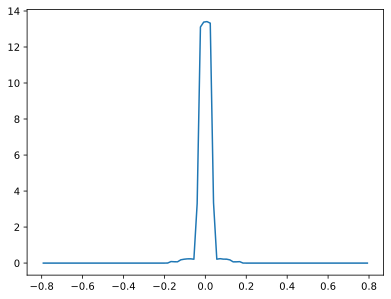

In [44]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])

  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy

# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

In [45]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 100

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses and accuracies
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize histogram variables
  histx = np.zeros((numepochs,100))
  histy = np.zeros((numepochs,100))


  # loop over epochs
  for epochi in range(numepochs):

    # get the weights distribution at the start of this epoch
    histx,histy[epochi,:] = weightsHistogram(net)

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches        = torch.argmax(yHat,axis=1) == y # booleans (false/true)
      matchesNumeric = matches.float()                # convert to numbers (0/1)
      accuracyPct    = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )                  # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy

In [37]:
trainAcc,testAcc,losses,net,histx,histy = function2trainTheModel()

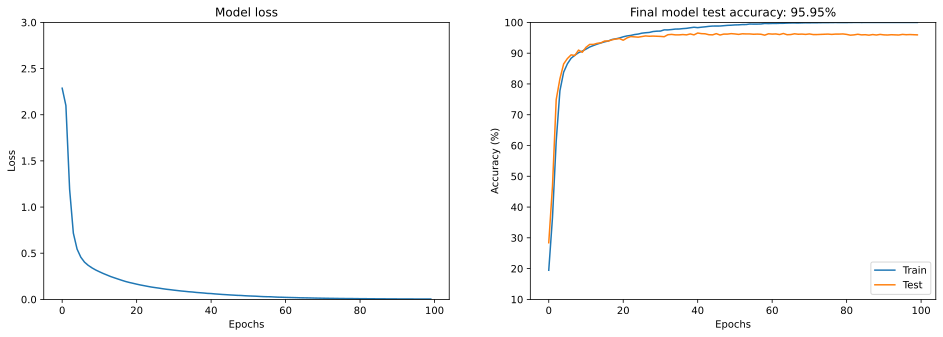

In [46]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()